In this notebook I reconstruct images using one autoencoder trained to reconstruct bare soil. Images have been obtained from GEE --> Landsat 8: seasonal composite (4 seasons) during one year (2015) and bands:  'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'.

In [1]:
base_path = '/cats/datastore3/claraenv/code/my-projects/'  # '/home/clara/'  # '/cats/datastore3/claraenv/code/my-projects/'  # '/home/clara/Documents/'

# Libraries

In [2]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip
from random import randint
import math
import re
import random

'''Data Viz'''
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
import matplotlib.cm as cm
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import joblib 

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

from osgeo import gdal
from osgeo import gdal_array
import matplotlib.pyplot as plt
import numpy as np
import sys
from osgeo.gdalconst import *
import os

import math
import codecs

import osgeo #this is necessary for the type comparison in some methods
from osgeo import osr
from osgeo import ogr
from collections import defaultdict
import itertools
from osgeo import gdal_array as gdar
from osgeo import gdalconst as gdct
import glob

# Paths

In [16]:
name_image = 'image_1'
image_path = f'{base_path}autoencoders/bare_soil-detection/data/google-earth-engine/{name_image}.tif'
array_path = f'{base_path}autoencoders/bare_soil-detection/results/image_arrays/{name_image}.npy'
figures_path = f'{base_path}autoencoders/bare_soil-detection/figures/'
mf = f'{base_path}/autoencoders/bare_soil-detection/models/'
out_diff_path = f'{base_path}autoencoders/bare_soil-detection/results/error/diff_{name_image}.npy'

# Reconstruction

**WARNING:** Puede dar error si el modelo (scaler) ha sido calculado en otro ordenador por incompetencia de versiones. En ese caso volver a ejecutar el notebook: autoencoder.ipynb

In [4]:
start_p = time.time()

# import array
vector = np.load(array_path)

# Models
model = keras.models.load_model(mf)
scaler = joblib.load(f'{base_path}/autoencoders/bare_soil-detection/models/scale.mod')

# Scale
vector_scaled = scaler.transform(vector)

# Predict
prediction_scaled = model.predict(x=vector_scaled, verbose=1)

# Descale
prediction = scaler.inverse_transform(prediction_scaled)

end_p = time.time()
print(f'Prediction time ---minutes--- {(end_p-start_p)/60}')

99705/99705 [==============================] - 287s 3ms/step
Prediction time ---minutes--- 4.80700585047404


# Reshape prediction to image shape

In [5]:
# import original image
image = gdal_array.LoadFile(image_path)
print('image shape:', image.shape)

# transpose to bands x pixels
pred_transpose = np.transpose(prediction)
print('prediction transposed', pred_transpose.shape)

# split the 4 seasons
pred_split = np.array(np.split(pred_transpose, indices_or_sections=4, axis = 1))
print('prediction splitted (seasons, bands, rows x columns):', pred_split.shape)

# split columns and rows
pred_reshape = pred_split.reshape(pred_split.shape[0], pred_split.shape[1], image.shape[1], image.shape[2])
print('prediction reshaped (seasons, bands, rows, columns):', pred_reshape.shape)

# delete date band
pred_nodate = pred_reshape[:,:-1,:,:]
print('prediction nodate (seasons, bands, rows, columns)', pred_nodate.shape)

# join seasons and bands
prediction = pred_nodate.reshape(image.shape[0], image.shape[1], image.shape[2])
print('prediction (bands x seasons, rows, columns)', prediction.shape)

image shape: (28, 391, 2040)
prediction transposed (8, 3190560)
prediction splitted (seasons, bands, rows x columns): (4, 8, 797640)
prediction reshaped (bands, seasons, rows, columns): (4, 8, 391, 2040)
prediction nodate (bands x seasons, rows, columns) (4, 7, 391, 2040)
prediction (bands x seasons, rows, columns) (28, 391, 2040)


# Error

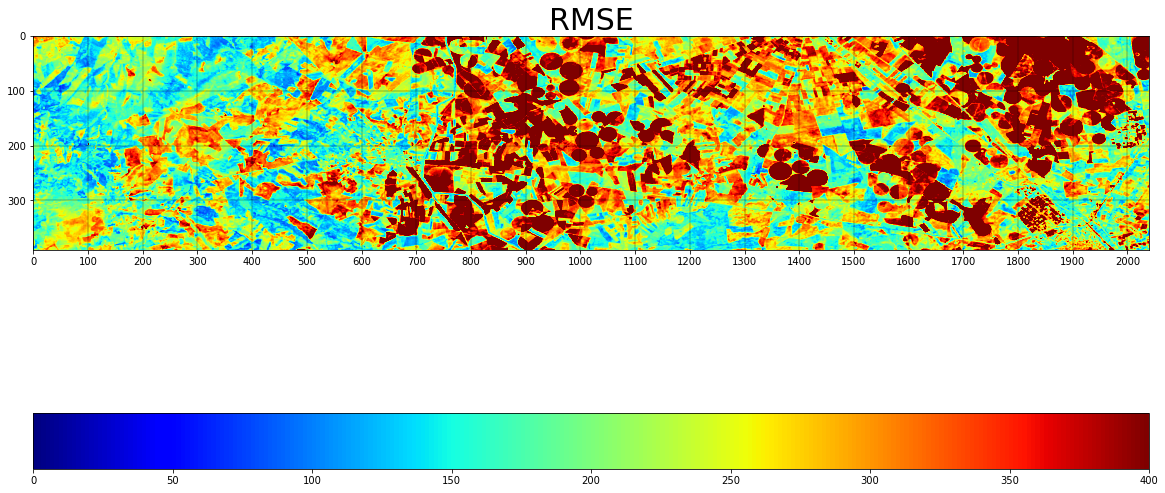

In [9]:
# Calculate RMSE in each vector u = (b1_winter, b2_winter, ..., b7_winter, b1_spring, ..., b7_spring, ...)
dif = (prediction-image)**2  # (prediction[:,:,:]-image[:,:,:])**2
suma = np.sum(dif, axis = 0)
div = suma/(image.shape[0])
error = div**(1/2)

# Plot RMSE
plt.figure(figsize=(20,20))
plt.imshow(error, cmap='jet', vmin= 0, vmax = 400)
plt.xticks(np.arange(error.shape[1]+1, step=100))
plt.yticks(np.arange(error.shape[0]+1, step=100))
plt.grid(color='black', linewidth=0.3)
plt.title(f'RMSE', fontsize=30)
cb = plt.colorbar(orientation="horizontal", pad=0.15)
plt.savefig(f'{figures_path}/RMSE.png', format='png', dpi=50)
plt.show()

In [17]:
# save difference
difference = (prediction-image)
np.save(out_diff_path, difference)

# Show prediction

(4, 7, 391, 2040)


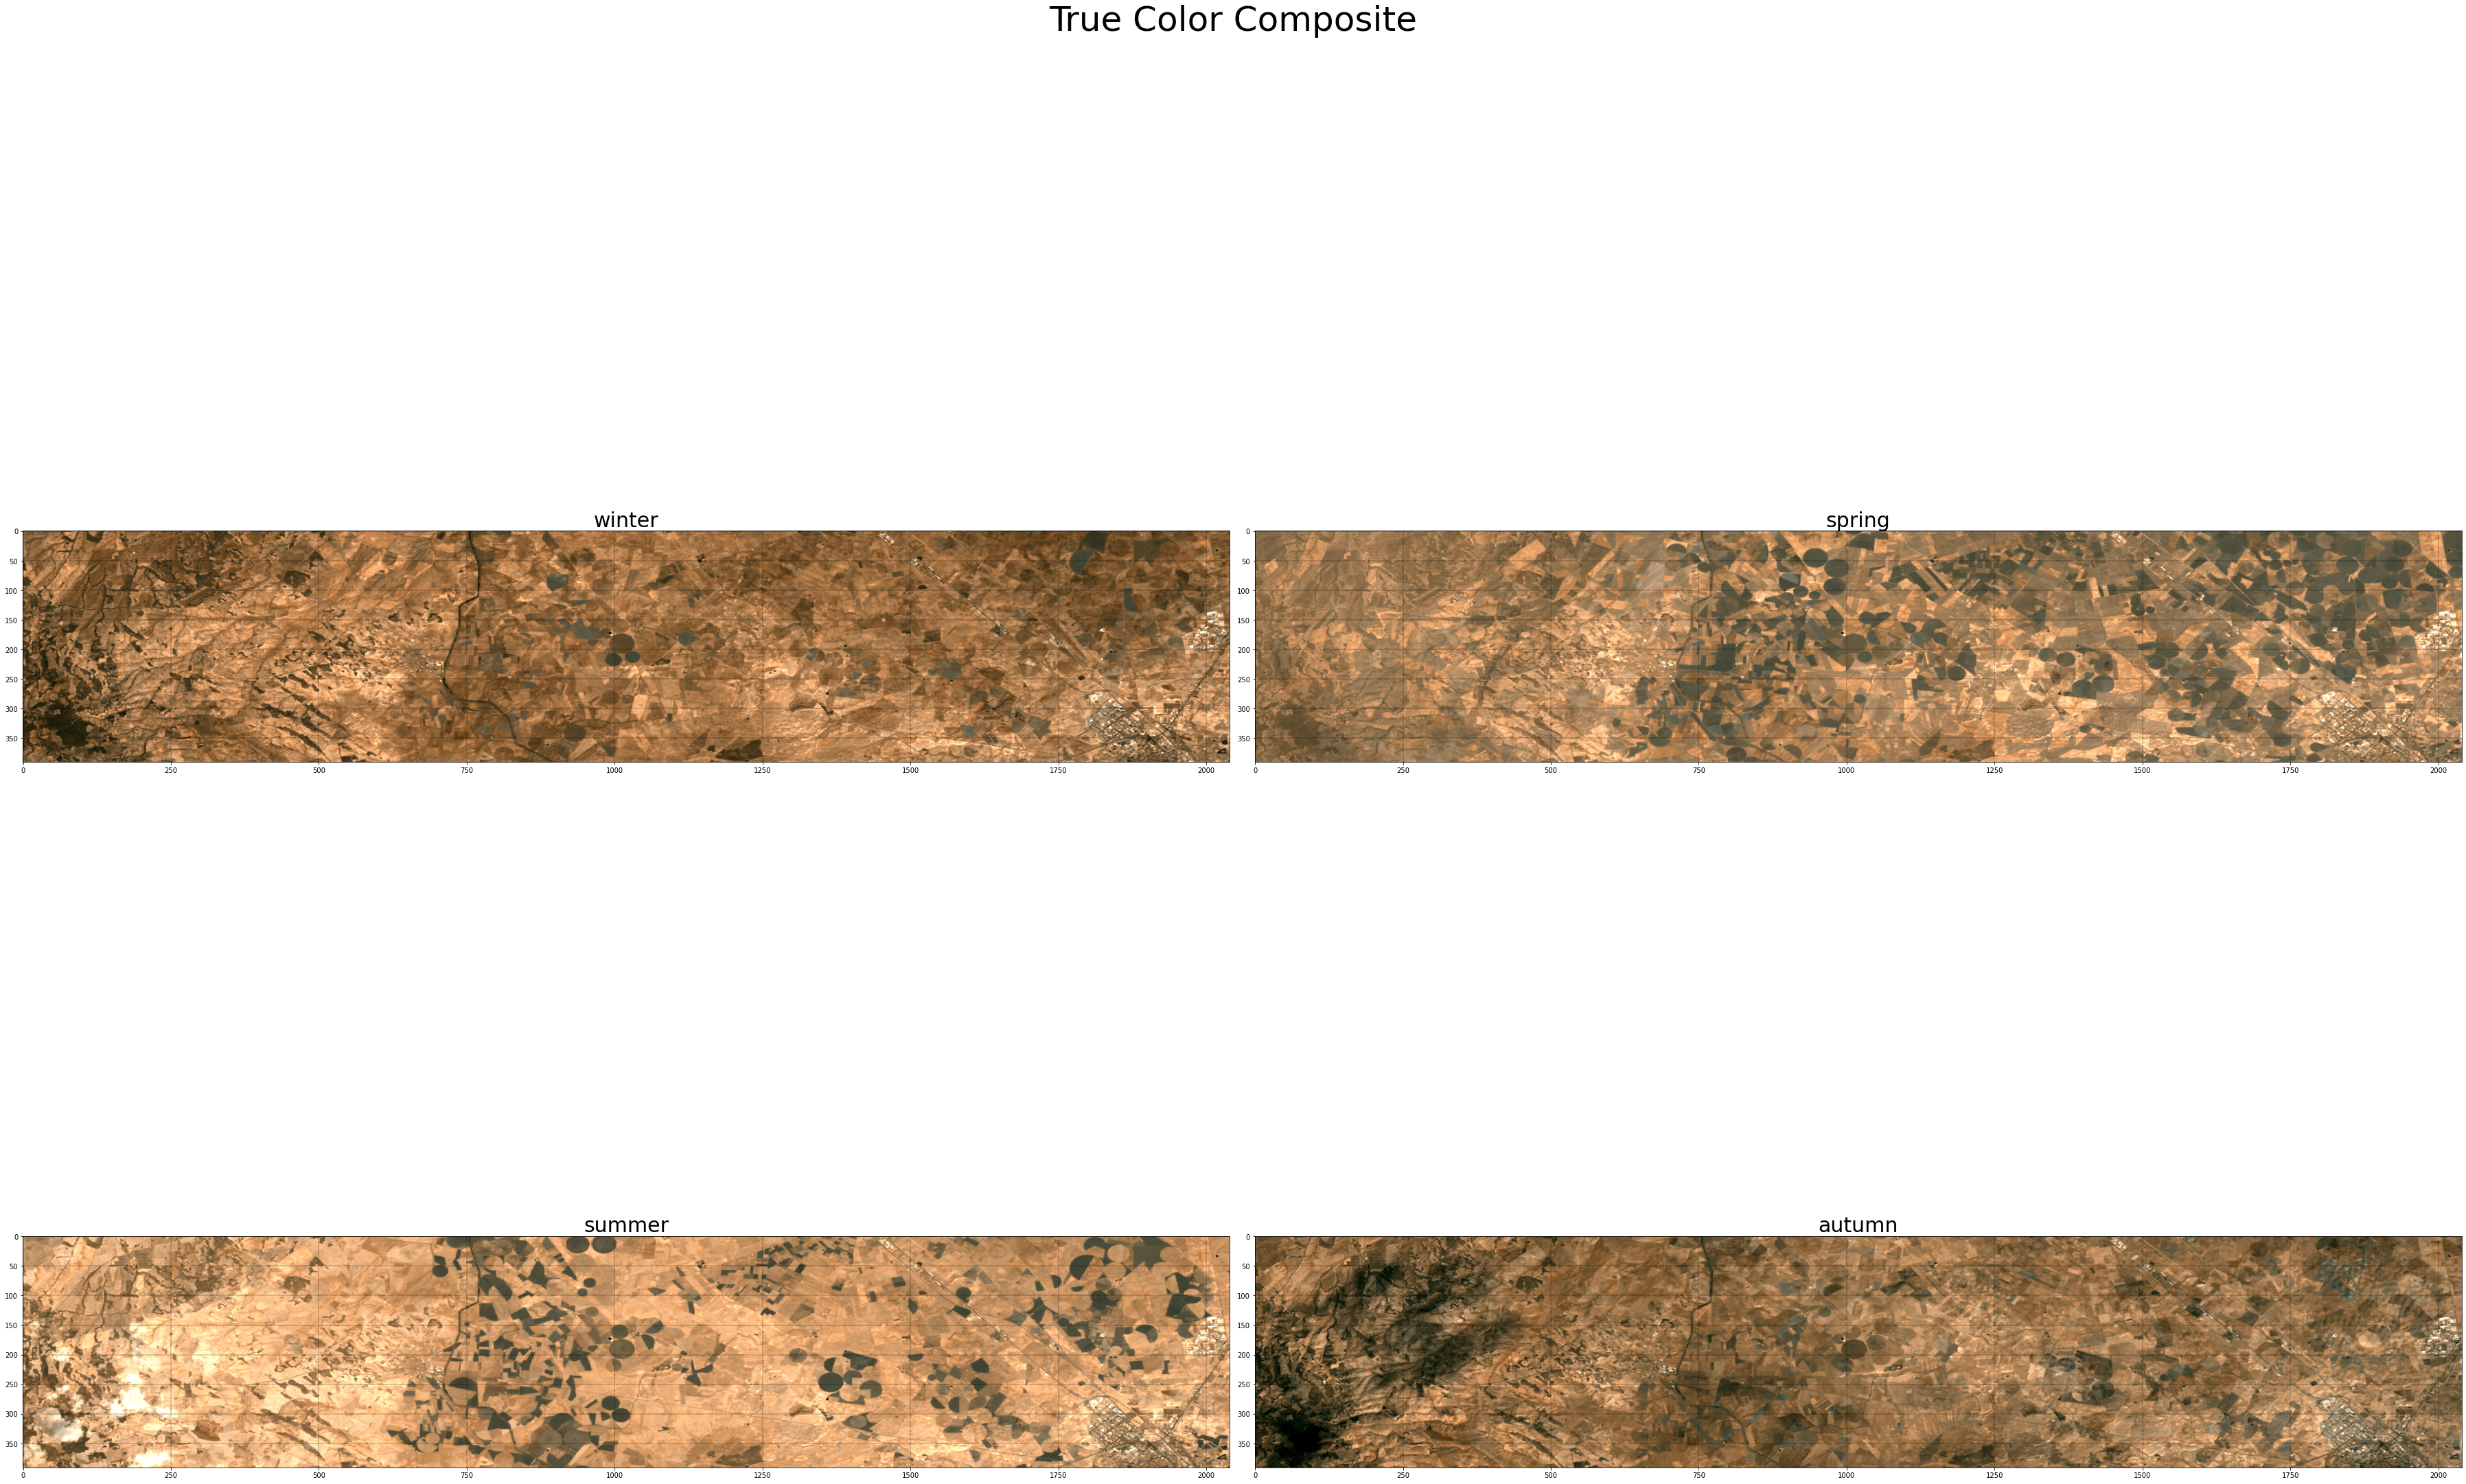

In [18]:
# Divide the 4 images for (winter, spring, summer and autumn)
seasons = ['winter', 'spring', 'summer', 'autumn']
prediction_seasons = np.array(np.split(prediction, len(seasons)))
print(prediction_seasons.shape)

# Fill in number of figures:
n_figures = len(seasons)

# Prepare number of columns and rows based on number of figures
n_rows = int(math.ceil((n_figures)**(1/2)))
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Subplots and figure title
fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
fig.suptitle(f'True Color Composite', fontsize = 50)

# Plot images
for sp in range(n_figures):
    prediction_season = prediction_seasons[sp]
    img = np.dstack((prediction_season[3, ...]/3000, prediction_season[2, ...]/3000, prediction_season[1, ...]/3000))
    img = np.clip(img, 0, 1)
    ax = axs[rows[sp], columns[sp]]
    img = ax.imshow(np.array(img))
    ax.grid(color='black', linewidth=0.3)
    ax.set_title(f'{seasons[sp]}', fontsize=30)

# delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()

# save
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(f'{figures_path}/prediction_TCC.png', format='png', dpi=50)
plt.show()

# End :)